In [2]:
import numpy as np
import math 
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.animation import FuncAnimation
import random
import taichi as ti
import taichi.math as tm

ti.init(arch=ti.gpu)

d = 1.001
dx = 0.001
N = int(d/dx)  # 空间分割
V1 = 0# 左侧电势
V2 = 2  # 右侧‘透镜’
# V4 = -0.3 # 左侧‘透镜’
V3 = V1# 右侧电势



[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.7.6
[Taichi] Starting on arch=cuda


In [3]:
potential = ti.field(dtype=ti.f64, shape = (N,N))    # 电势场
E = ti.Vector.field(n=2, shape = (N, N), dtype=ti.f64)  #电场

In [4]:
@ti.kernel
def boundary_condition():      
    ''' 边界条件， 设置左右及上下V
    '''
    for i, j in potential:
        if  i <int(N/3)-1  or i >  2 * int(N/3)-1:
            if j == int(N/3)-1 :
                potential[i, j] = V1
            if j == 2 * int(N/3)-1:
                potential[i, j] = V3
            
        if i == 0 or i == N-1:  
            if j <= int(N/3)-1:
                potential[i, j] = V1
            if j >= 2 * int(N/3)-1:
                potential[i, j] = V3
            


        if j == 0:
            potential[i, j] = V1
        if j == N-1:
            potential[i, j] = V3

        if j == int(N/2)-1 :
            if  i <int(N/3)-1  or i >  2 * int(N/3)-1:
                potential[i, j] = V2

        
    # potential[int(N/2), int(N/2)] = 1
            

        # if i == 0 or i == N-1:
        #     if 0.1* N < j < 0.2 * N:
        #         potential[i, j] = V4



In [5]:
@ti.kernel
def update():
    ''' 电势更新 有限差分法更新
    '''
    for i, j in potential:
        if j ==0 or j == N-1:
            potential[i, j] = potential[i, j]
        else:
            if i == 0:
                # a = potential[i, j] + potential[i + 1, j] + potential[i, j+1] + potential[i, j-1]
                a = potential[i, j] * 2 + potential[i, j+1] + potential[i, j-1]
                potential[i, j] = 0.25 * a 
            elif i == N-1 :
                # a =  potential[i, j] + potential[i - 1, j] + potential[i, j+1] + potential[i, j-1]
                a = potential[i, j] * 2 + potential[i, j+1] + potential[i, j-1]
                potential[i, j] = 0.25 * a 
            else:
                a = potential[i+1, j] + potential[i - 1, j] + potential[i, j+1] + potential[i, j-1]
                potential[i, j] = 0.25 * a 





In [6]:
''' 迭代得到电势场
'''

for i in range(200000):
    boundary_condition()
    update()
    




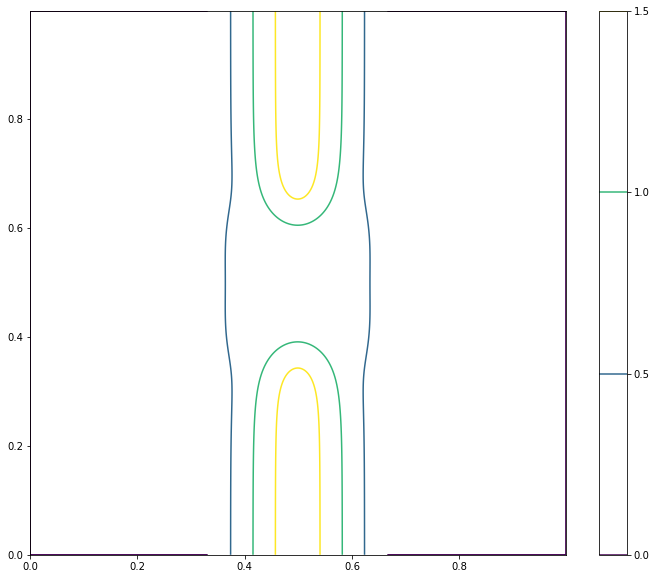

In [7]:
'''
绘制等势线图
'''

potential_array = potential.to_numpy()


CTN = np.arange(V1, V2, 0.5)      # 等高线密度
fig1 = plt.figure(1, figsize = (12,10)) 

x = np.arange(0, N*dx, dx) 
y = np.arange(0, N*dx, dx) 

CT = plt.contour(x, y, potential_array, CTN)  # 绘制等高线

plt.colorbar(CT)

np.savetxt('potential.txt', potential_array)


In [8]:


@ti.kernel
def potential_to_E():
    ''' 直接做差分得到电场
    '''
    for k, l in potential:
        if k != 0 and k != N-1:
            if l != 0 and l != N-1:
                y = - (potential[k+1, l] - potential[k-1, l])/(2 * dx)
                x = - (potential[k, l+1] - potential[k, l-1])/(2 * dx)
                E[k,l] = ti.math.vec2(x, y)


potential_to_E()



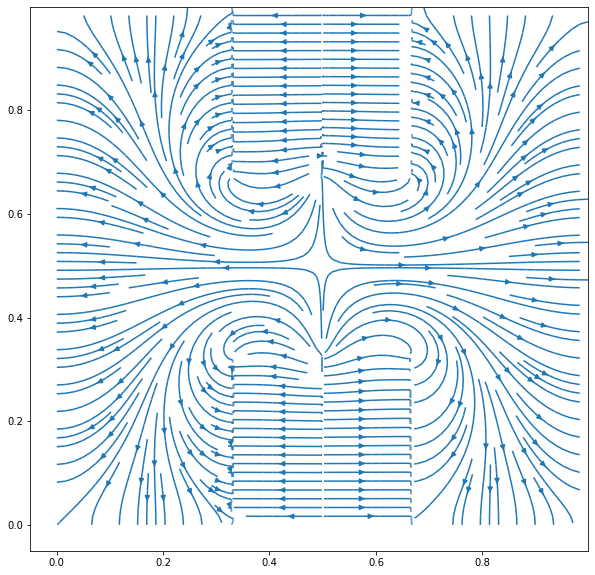

In [9]:
'''绘制电场'''

# X, Y = np.mgrid[0:N, 0:N]
U = np.zeros((N, N))
V = np.zeros((N, N))
E_list = E.to_numpy()


for i in range(N):
    for j in range(N):
        U[i][j] = E_list[i][j][0]
        V[i][j] = E_list[i][j][1]

fig1 = plt.figure(1, figsize=(10,10))
x = np.arange(0, N*dx, dx) 
y = np.arange(0, N*dx, dx) 

plt.streamplot(x, y, U, V, density=2)


In [10]:
'''particle moving in the field '''

m_e = 1 # mass of the charged particle
q_e = -1 # the charge of the particle
nu = q_e/m_e # 荷质比


dt = 0.0001

def init():
    '''电子初始条件'''
    x = dx
    y = N * dx * random.random()
    
    return [x, y]

def E_r(r):
    '''r处电场'''
    x = r[0]
    y = r[1]
    a = int(x//dx) 
    b = int(y//dx) 
    a_1 = a - 1
    b_1 = b - 1
    Ex_0 = E[b, a][0]
    Ey_0 = E[b, a][1]
    Ex_1 = E[b_1, a_1][0]
    Ey_1 = E[b_1, a_1][1]

    Ex = 0.5 * (Ex_0 + Ex_1)
    Ey = 0.5 * (Ey_0 + Ey_1)


    # return [Ex, Ey]
    return E[b, a]

def update_v(v, r):
    '''带电粒子速度更新'''
    vx = v[0]
    vy = v[1]
    E = E_r(r)
    Ex = E[0]
    Ey = E[1]
    vx_1 = vx + nu * Ex * dt
    vy_1 = vy + nu * Ey * dt
    return [vx_1, vy_1]

def update_r(v, r):
    '''带电粒子位置更新'''
    vx = v[0]
    vy = v[1]
    x = r[0]
    y = r[1]
    x_1 = x + vx * dt
    y_1 = y + vy * dt
    return [x_1, y_1]



c:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'lw'
  if __name__ == '__main__':


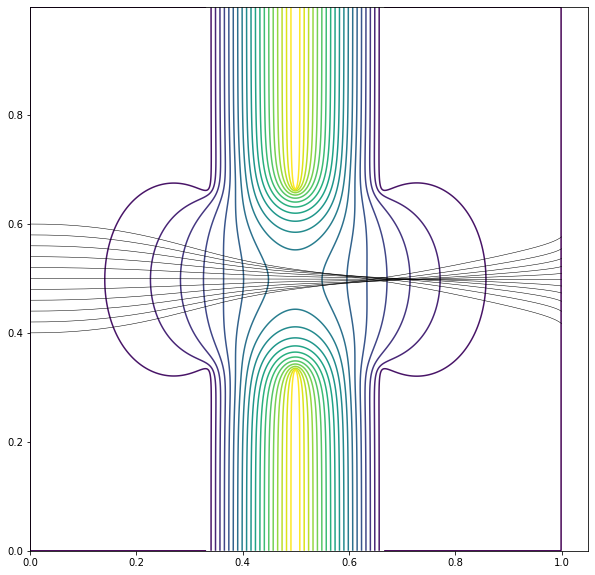

In [12]:
''' plot trajectories of particles with field
'''

fig3 = plt.figure(3, figsize=(10,10))
x = np.arange(0, N*dx, dx) 
y = np.arange(0, N*dx, dx) 
# plt.streamplot(x, y, U, V, density=0.8,color = "grey" )
CTN = np.arange(V1, V2, 0.1)
CT = plt.contour(x, y, potential_array, CTN, lw = 0.5)

for y in np.arange(d/2-0.1, d/2+0.101, 0.02):
        r = [dx, y]
        v = [0.1, 0]

        r_x = []
        r_y = []

        while r[0] < N * dx and r[1] < N * dx:
        # for _ in range(20000):
                v = update_v(v, r)
                r = update_r(v, r)
                r_x.append(r[0])
                r_y.append(r[1])
                

        potential_array = potential.to_numpy()
        plt.plot(r_x, r_y, color = 'black', lw = 0.5) 





plt.savefig('dt=0.0001,020.png', dpi  = 200)
